Загрузим все необходимые библиотеки

In [1]:
import cv2 
import os
from shutil import copy2
from random import shuffle
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable

Шаг 1. Подготовка данных

Создадим объекты для необходимых трансформаций нашего датасета:

In [2]:
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.Resize((48, 48)),
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

test_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                        tt.Resize((48, 48)), tt.ToTensor()])

Для обучения нейронной сети будем использовать этот [датасет](https://www.kaggle.com/chiragsoni/ferdata?) (54 MB).
Загрузим его и распакуем содержимое в папку 'Emotion_recognition'.

Видим, что внутри две папки с тестовыми и тренировочными картинками:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/PyTorch/'

In [5]:
class_list = []
folder_list = []
basedir = '/content/drive/MyDrive/PyTorch/data/'

for folder_ in os.listdir(basedir):
    for class_ in os.listdir(basedir+folder_+'/'):
        class_list.append(class_)
        folder_list.append(folder_)

class_list = list(set(class_list))
folder_list = list(set(folder_list))
print(class_list)
print(folder_list)

['G3', 'G1', 'G4', 'G10', 'G7', 'G6', 'G2', 'G5', 'G9', 'G11', 'G8']
['S3', 'S1', 'S2', 'S4']


In [6]:
# cd /content/drive/MyDrive/PyTorch/new_data/

In [7]:
# os.mkdir('train')
# os.mkdir('test')

In [8]:
# cd test

# for i in class_list:
#     os.mkdir(i)

# cd ..
# cd train

# for i in class_list:
#     os.mkdir(i)

In [9]:
# sort_list = ['train' for i in range(27)]
# sort_list.extend(['test' for i in range(3)])
# shuffle(sort_list)

# basedir = '/content/drive/MyDrive/PyTorch/data/'
# base_outdir = '/content/drive/MyDrive/PyTorch/new_data/'
# train_val = 0

# for folder_ in folder_list:
#     for class_ in class_list:
#         original_path = basedir + folder_ + '/' + class_ +'/'
#         for dirname, _, filenames in os.walk(original_path):
#             train_val = 0
#             for filename in filenames:
#                 if filename.endswith('.png'):
#                     outdir = base_outdir + sort_list[train_val] + '/'
#                     new_path = os.path.join(original_path, filename)
#                     copy_path = os.path.join(outdir + class_ + '/', filename)

#                     if os.path.isfile(copy_path):
#                         new_filename = str(len(os.listdir(outdir + class_ + '/'))) + filename 
#                         copy_path = os.path.join(outdir + class_ + '/', new_filename)

#                     copy2(new_path, copy_path)
#                     train_val += 1
                    

Если посмотрим что в них, то у видим 7 папок. Каждая под один из 7 классов эмоций:

In [10]:
classes_train = os.listdir('/content/drive/MyDrive/PyTorch/new_data/train')
classes_test = os.listdir('/content/drive/MyDrive/PyTorch/new_data/test')
print(f'Train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

Train Classes - ['G6', 'G7', 'G8', 'G10', 'G11', 'G4', 'G3', 'G5', 'G9', 'G1', 'G2']
test Classes - ['G6', 'G7', 'G8', 'G10', 'G11', 'G4', 'G3', 'G5', 'G9', 'G1', 'G2']


In [11]:
for emotion in os.listdir('/content/drive/MyDrive/PyTorch/new_data/train'):
    print(emotion, len(os.listdir(f'/content/drive/MyDrive/PyTorch/new_data/train/{emotion}')))

G6 108
G7 108
G8 108
G10 108
G11 108
G4 108
G3 108
G5 108
G9 108
G1 108
G2 108


In [12]:
def digit_to_classname(digit):
    if digit == 0:
        return 'G6'
    elif digit == 1:
        return 'G7'
    elif digit == 2:
        return 'G8'
    elif digit == 3:
        return 'G10'
    elif digit == 4:
        return 'G11'
    elif digit == 5:
        return 'G4'
    elif digit == 6:
        return 'G3'
    elif digit == 7:
        return 'G5'
    elif digit == 8:
        return 'G9'
    elif digit == 9:
        return 'G1'
    elif digit == 10:
        return 'G2'

Используем ImageFolder для каждой выборки:

In [13]:
train_ds = ImageFolder('/content/drive/MyDrive/PyTorch/new_data/train', train_tfms)
test_ds = ImageFolder('/content/drive/MyDrive/PyTorch/new_data/test', test_tfms)

In [14]:
train_ds

Dataset ImageFolder
    Number of datapoints: 1188
    Root location: /content/drive/MyDrive/PyTorch/new_data/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(48, 48), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

In [15]:
train_ds.classes

['G1', 'G10', 'G11', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9']

Определим размер батча:

In [16]:
batch_size = 64



















И создадим наши даталоадеры:

In [17]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

torch.Size([1, 48, 48])
tensor(1) G7


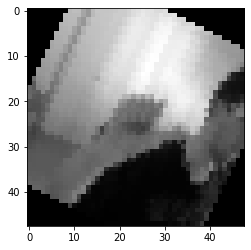

In [18]:
for img, l in train_dl:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0)[:,:,0], cmap='gray')
    break

Создадим функцию для просмотра случайных картинок из получившегося датасета:

In [19]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 48, 48])


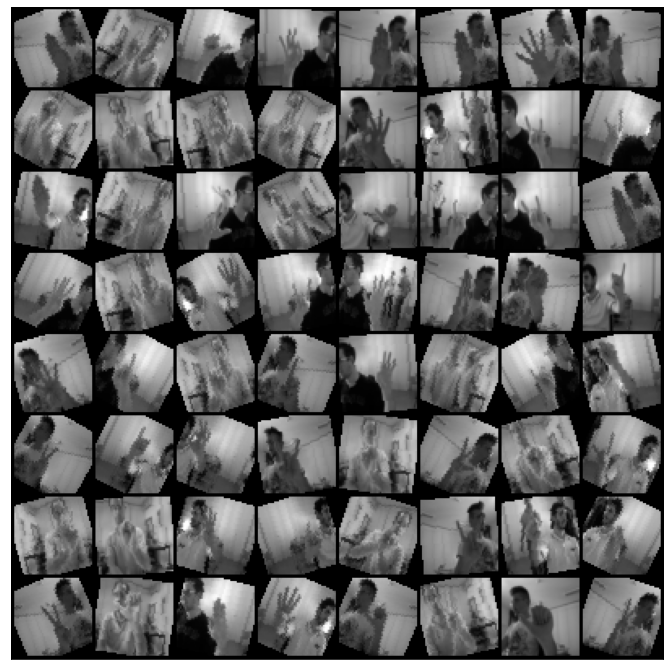

In [20]:
show_batch(train_dl)

Узнаем какое оборудование у нас:

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Шаг 2. Опишем модель

Опишем нашу модель для распознавания эмоций:

In [22]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

BatchNorm2d - вывод со сверточного слоя может быть довольно большим, что может негативно повлиять на нашу модель. А этот слой просто нормализует полученные данные.

ELU - можно использовать и Relu.

In [23]:
model = ResNet(1, len(classes_train)).to(device)

In [24]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

Шаг 3. Обучение

In [25]:
epochs = 30
max_lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), max_lr)

In [26]:
epoch_losses = []

for epoch in range(epochs):
    
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dl):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        
    test_running_loss = 0
    test_epoch_loss = []
    for batch_idx, (data, labels) in enumerate(test_dl):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
                
        test_running_loss += loss.item()
        test_epoch_loss.append(loss.item())
        
        
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss), 'test loss:', np.mean(test_epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 1, loss:  3.8247919208125065 test loss: 3.0408100287119546
Epoch 2, loss:  3.389339986600374 test loss: 2.873120387395223
Epoch 3, loss:  2.9127375201175085 test loss: 2.2777373790740967
Epoch 4, loss:  2.579422298230623 test loss: 2.4655444622039795
Epoch 5, loss:  2.5758552174819145 test loss: 2.5850510597229004
Epoch 6, loss:  2.5453062433945504 test loss: 2.585745175679525
Epoch 7, loss:  2.4337183676267924 test loss: 2.7622620264689126
Epoch 8, loss:  2.3278721257259973 test loss: 2.370827833811442
Epoch 9, loss:  2.261659860610962 test loss: 1.8727758328119914
Epoch 10, loss:  2.1853534673389636 test loss: 1.8328495422999065
Epoch 11, loss:  2.131189220830014 test loss: 1.7137742042541504
Epoch 12, loss:  1.8850263419904207 test loss: 1.3497700691223145
Epoch 13, loss:  1.762341022491455 test loss: 1.4196621576944988
Epoch 14, loss:  1.6090876930638363 test loss: 1.2209165493647258
Epoch 15, loss:  1.5236460033215975 test loss: 1.2861544291178386
Epoch 16, loss:  1.20843811

Посмотрим на нашу ошибку в процессе обучения:

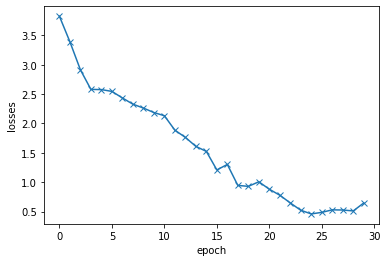

In [27]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses');

Сохраним нашу модель:

In [28]:
torch.save(model, './gesture_detection_model_state.pth')

Теперь давайте загрузим ее и будем использовать:

In [29]:
net = torch.load('./gesture_detection_model_state.pth')
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [30]:
classes = train_ds.classes

In [31]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
img_path = '/content/drive/MyDrive/PyTorch/test/G10/10-color.png'
mtcnn = MTCNN()

In [33]:
img_path_ = '/content/drive/MyDrive/PyTorch/test/'

In [34]:
test_ds = ImageFolder(img_path_, test_tfms)

In [35]:
test_dl = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

In [36]:
net.eval()
for data in test_dl:
  test_outputs = net(data[0].to(device))
  label = data[1].to(device) 
  predict = torch.max(test_outputs, 1)[1]
  break


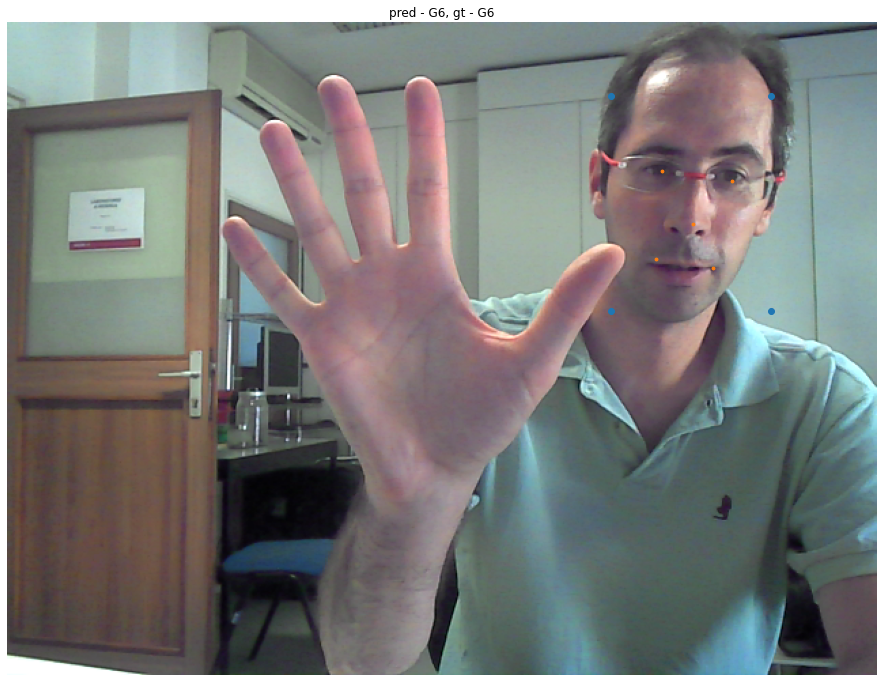

In [37]:
frame = cv2.imread(img_path)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

# Detect face
boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)

# Visualize
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(frame)
ax.axis('off')
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = net(images)
        plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')

for box, landmark in zip(boxes, landmarks):
    ax.scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]))
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8)
fig.show()